In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as utils
import matplotlib.animation as animation
from IPython.display import HTML
import time
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn.functional as F
from scipy import linalg
import pandas as pd

In [50]:
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:',device)
LEARNING_RATE = 5e-5
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 3  
NOISE_DIM = 100
NUM_EPOCHS = 50
FEATURES_DISC = 64 
FEATURES_GEN = 64 
beta = 0.5


Device: cuda


In [51]:
import os
if not os.path.exists('Results'):
   os.makedirs('Results')
if not os.path.exists('Models'):
   os.makedirs('Models')

In [52]:
dataset = datasets.CIFAR10(root="dataset", download=True,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)

Files already downloaded and verified


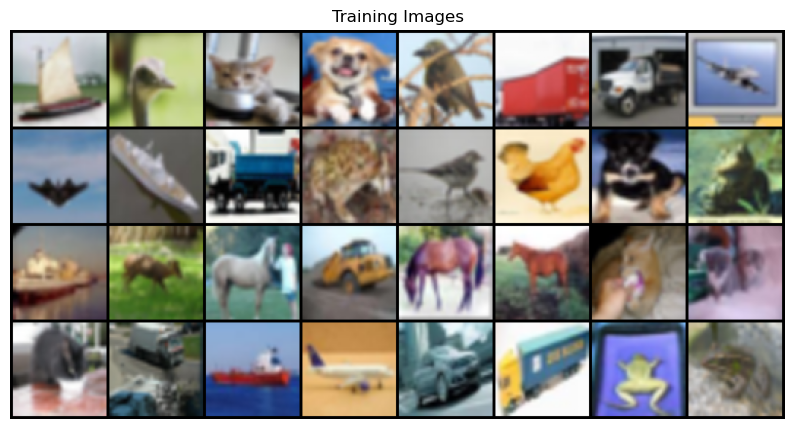

In [53]:
# Fetch a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Set up the figure for displaying the images
plt.figure(figsize=(10, 10))  # Set figure size
plt.axis("off")  # Turn off the axis for a cleaner display
plt.title("Training Images")  # Add a title

# Create a grid of images and display it
plt.imshow(
    np.transpose(
        utils.make_grid(
            real_batch[0].to(device)[:32],  # Select the first 32 images in the batch
            padding=2,                     # Add padding between images
            normalize=True                 # Normalize pixel values for visualization
        ).cpu(),
        (1, 2, 0)  # Transpose the tensor to match image format (H, W, C)
    )
)

# Show the plot
plt.show()


In [54]:
import torch.nn as nn

class Discriminator(nn.Module):
    """
    Discriminator class for a GAN, designed to process 64x64 images.
    Outputs a single scalar representing the validity of the input.
    """
    def __init__(self, channels_img, features_d):
        """
        Initialize the Discriminator network.

        Parameters:
        - channels_img: Number of image channels (e.g., 3 for RGB).
        - features_d: Base feature size for the network.
        """
        super(Discriminator, self).__init__()
        
        # Define the discriminator network
        self.disc = nn.Sequential(
            # Initial convolution: Reduce image size from 64x64 to 32x32
            nn.Conv2d(
                in_channels=channels_img,
                out_channels=features_d,
                kernel_size=4,
                stride=2,
                padding=1,
            ),
            nn.LeakyReLU(0.2),

            # Stacked blocks: Reduce image size from 32x32 to 16x16, then 8x8, and finally 4x4
            self._discriminator_block(features_d, features_d * 2, 4, 2, 1),
            self._discriminator_block(features_d * 2, features_d * 4, 4, 2, 1),
            self._discriminator_block(features_d * 4, features_d * 8, 4, 2, 1),

            # Final convolution: Reduce size from 4x4 to 1x1 (output a single scalar)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),  # Sigmoid activation for output validity score
        )

    def _discriminator_block(self, in_channels, out_channels, kernel_size, stride, padding):
        """
        Helper function to create a discriminator block with a convolution and LeakyReLU.
        """
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=False,
            ),
            # Batch normalization can be enabled if needed for stability
            # nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        """
        Forward pass of the Discriminator.

        Parameters:
        - x: Input tensor of shape (N, channels_img, 64, 64).

        Returns:
        - Validity score: Tensor of shape (N, 1, 1, 1) where N is the batch size.
        """
        return self.disc(x)


In [55]:
import torch.nn as nn

class Generator(nn.Module):
    """
    Generator class for a GAN, designed to generate 64x64 images from noise.
    Takes a noise vector as input and outputs an image.
    """
    def __init__(self, channels_noise, channels_img, features_g):
        """
        Initialize the Generator network.

        Parameters:
        - channels_noise: Number of channels in the input noise vector.
        - channels_img: Number of channels in the output image (e.g., 3 for RGB).
        - features_g: Base feature size for the network.
        """
        super(Generator, self).__init__()
        
        # Define the generator network
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._generator_block(channels_noise, features_g * 16, 4, 1, 0),  # Output: 4x4
            self._generator_block(features_g * 16, features_g * 8, 4, 2, 1),  # Output: 8x8
            self._generator_block(features_g * 8, features_g * 4, 4, 2, 1),  # Output: 16x16
            self._generator_block(features_g * 4, features_g * 2, 4, 2, 1),  # Output: 32x32
            nn.ConvTranspose2d(
                in_channels=features_g * 2,
                out_channels=channels_img,
                kernel_size=4,
                stride=2,
                padding=1,
            ),  # Output: 64x64
            nn.Tanh(),  # Normalize output to range [-1, 1]
        )

    def _generator_block(self, in_channels, out_channels, kernel_size, stride, padding):
        """
        Helper function to create a generator block with ConvTranspose2d,
        BatchNorm2d, and ReLU activation.
        """
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels, momentum=0.9),  # Batch normalization for stability
            nn.ReLU(),  # ReLU activation for non-linearity
        )

    def forward(self, x):
        """
        Forward pass of the Generator.

        Parameters:
        - x: Input tensor of shape (N, channels_noise, 1, 1).

        Returns:
        - Generated image tensor of shape (N, channels_img, 64, 64).
        """
        return self.net(x)


In [56]:
def initialize_weights(model):
    """
    Initialize the weights of Conv2d, ConvTranspose2d, and BatchNorm2d layers
    using a normal distribution with mean=0.0 and std=0.02, as per the DCGAN paper.

    Parameters:
    - model: The PyTorch model whose weights need to be initialized.
    """
    for layer in model.modules():
        if isinstance(layer, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(layer.weight.data, mean=0.0, std=0.02)  # Apply normal distribution


In [57]:
# Instantiate the Generator and Discriminator
gen = Generator(
    channels_noise=NOISE_DIM,        # Dimensionality of the input noise vector
    channels_img=CHANNELS_IMG,      # Number of channels in the output image (e.g., 3 for RGB)
    features_g=FEATURES_GEN         # Base feature size for the Generator
).to(device)                        # Move the Generator to the specified device

disc = Discriminator(
    channels_img=CHANNELS_IMG,      # Number of channels in the input image (e.g., 3 for RGB)
    features_d=FEATURES_DISC        # Base feature size for the Discriminator
).to(device)                        # Move the Discriminator to the specified device

# Initialize the weights of both models
initialize_weights(gen)
initialize_weights(disc)


In [58]:
# Define optimizers for Generator and Discriminator
optimGenerator = optim.Adam(
    gen.parameters(),          # Parameters of the Generator
    lr=LEARNING_RATE,          # Learning rate for the Generator
    betas=(beta, 0.999)        # Beta values for Adam optimizer (common in GANs)
)

optimDiscriminator = optim.Adam(
    disc.parameters(),         # Parameters of the Discriminator
    lr=LEARNING_RATE,          # Learning rate for the Discriminator
    betas=(beta, 0.999)        # Beta values for Adam optimizer
)

# Define the loss function
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for real vs. fake classification

# Create fixed noise for evaluating the Generator's progress
fixed_noise = torch.randn(
    32, NOISE_DIM, 1, 1  # Fixed batch size of 32, noise dimension, and spatial size (1x1)
).to(device)             # Move the noise tensor to the appropriate device

# Initialize a step counter to track iterations
step = 0


In [59]:
gen.train(),disc.train()

(Generator(
   (net): Sequential(
     (0): Sequential(
       (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
       (1): BatchNorm2d(1024, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (1): Sequential(
       (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (2): Sequential(
       (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (3): Sequential(
       (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (4): C

In [60]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models


class InceptionV3(nn.Module):
    """
    Pretrained InceptionV3 network returning feature maps.
    Typically used for computing Frechet Inception Distance (FID).
    """

    # Default block index corresponds to the final average pooling layer
    DEFAULT_BLOCK_INDEX = 3

    # Mapping feature dimensions to InceptionV3 output block indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,    # First max pooling features
        192: 1,   # Second max pooling features
        768: 2,   # Pre-aux classifier features
        2048: 3,  # Final average pooling features
    }

    def __init__(self, output_blocks=None, resize_input=True, normalize_input=True, requires_grad=False):
        """
        Initialize the InceptionV3 model.

        Parameters:
        - output_blocks: List of blocks to extract features from (default: [DEFAULT_BLOCK_INDEX]).
        - resize_input: Whether to resize the input to (299, 299).
        - normalize_input: Whether to scale the input to the range [-1, 1].
        - requires_grad: If False, freezes the model parameters.
        """
        super(InceptionV3, self).__init__()

        if output_blocks is None:
            output_blocks = [self.DEFAULT_BLOCK_INDEX]

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, "Last possible output block index is 3."

        # Load pretrained InceptionV3 model and divide into blocks
        self.blocks = nn.ModuleList()
        inception = models.inception_v3(pretrained=True)

        # Block 0: Input to first max pooling
        self.blocks.append(nn.Sequential(
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2),
        ))

        # Block 1: From first to second max pooling
        if self.last_needed_block >= 1:
            self.blocks.append(nn.Sequential(
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2),
            ))

        # Block 2: Pre-auxiliary classifier features
        if self.last_needed_block >= 2:
            self.blocks.append(nn.Sequential(
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ))

        # Block 3: From auxiliary classifier to final average pooling
        if self.last_needed_block >= 3:
            self.blocks.append(nn.Sequential(
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1)),  # Global average pooling
            ))

        # Freeze parameters if gradient computation is not required
        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, x):
        """
        Forward pass through the InceptionV3 model.

        Parameters:
        - x: Input tensor of shape (N, 3, H, W).

        Returns:
        - List of feature maps from the specified output blocks.
        """
        outputs = []

        # Resize and normalize input if required
        if self.resize_input:
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
        if self.normalize_input:
            x = 2 * x - 1  # Normalize input from range [0, 1] to [-1, 1]

        # Pass input through each block and collect outputs
        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outputs.append(x)
            if idx == self.last_needed_block:
                break

        return outputs


# Instantiate the InceptionV3 model for extracting features with 2048 dimensions
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3(output_blocks=[block_idx])
model = model.cuda()  # Move the model to GPU


/home/gbusaga/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gbusaga/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [61]:
import numpy as np
from torch.nn.functional import adaptive_avg_pool2d

def calculate_activation_statistics(images, model, batch_size=128, dims=2048, use_cuda=False):
    """
    Compute the mean and covariance of feature maps for a set of images.

    Parameters:
    - images: A batch of images as a PyTorch tensor of shape (N, C, H, W).
    - model: Pretrained InceptionV3 model for feature extraction.
    - batch_size: Number of images processed in each batch (default: 128).
    - dims: Dimensionality of the feature vectors (default: 2048).
    - use_cuda: Whether to perform computation on GPU (default: False).

    Returns:
    - mu: The mean of the feature maps (numpy array of shape (dims,)).
    - sigma: The covariance matrix of the feature maps (numpy array of shape (dims, dims)).
    """
    # Ensure the model is in evaluation mode
    model.eval()

    # Initialize an empty array to store activations
    act = np.empty((len(images), dims))

    # Move images to GPU if use_cuda is True
    batch = images.cuda() if use_cuda else images

    # Extract features using the model
    with torch.no_grad():  # Disable gradient computation for efficiency
        pred = model(batch)[0]  # Get the first output block's feature maps

    # Apply global average pooling if the feature maps are not already 1x1
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    # Reshape the feature maps and move to CPU for further processing
    act = pred.cpu().data.numpy().reshape(pred.size(0), -1)

    # Compute the mean and covariance of the feature maps
    mu = np.mean(act, axis=0)  # Mean vector
    sigma = np.cov(act, rowvar=False)  # Covariance matrix

    return mu, sigma


In [62]:
import numpy as np
from scipy import linalg

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """
    Compute the Frechet Distance between two multivariate Gaussians.
    This is used for evaluating the similarity between two distributions, such as
    real and generated image feature maps, for FID computation.

    Parameters:
    - mu1, sigma1: Mean and covariance of the first distribution.
    - mu2, sigma2: Mean and covariance of the second distribution.
    - eps: A small value added to the diagonal of covariance matrices for numerical stability.

    Returns:
    - Frechet Distance (float): Measure of similarity between the two distributions.
    """
    # Ensure mean vectors and covariance matrices are numpy arrays
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)
    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    # Validate that dimensions of means and covariances match
    assert mu1.shape == mu2.shape, "Mean vectors must have the same dimensions."
    assert sigma1.shape == sigma2.shape, "Covariance matrices must have the same dimensions."

    # Compute the difference between mean vectors
    diff = mu1 - mu2

    # Compute the square root of the product of covariance matrices
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)

    # Handle numerical instability if covmean is not finite
    if not np.isfinite(covmean).all():
        print(f"FID calculation encountered numerical instability; adding {eps} to diagonal.")
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Ensure no complex values in covmean
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            raise ValueError(f"Complex values found in covariance matrix product.")
        covmean = covmean.real  # Use only the real part

    # Compute the trace of the square root covariance matrix
    tr_covmean = np.trace(covmean)

    # Calculate the Frechet Distance
    frechet_distance = (
        diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean
    )

    return frechet_distance


In [63]:
def calculate_fretchet(images_real, images_fake, model):
    """
    Compute the Frechet Inception Distance (FID) between two sets of images.

    Parameters:
    - images_real: Real images as a PyTorch tensor of shape (N, C, H, W).
    - images_fake: Generated (fake) images as a PyTorch tensor of shape (N, C, H, W).
    - model: Pretrained InceptionV3 model for feature extraction.

    Returns:
    - fid_value: The computed Frechet Inception Distance (FID) as a float.
    """
    # Calculate activation statistics for real and fake images
    mu_1, sigma_1 = calculate_activation_statistics(images_real, model, use_cuda=True)
    mu_2, sigma_2 = calculate_activation_statistics(images_fake, model, use_cuda=True)

    # Compute Frechet Inception Distance using the calculated statistics
    fid_value = calculate_frechet_distance(mu_1, sigma_1, mu_2, sigma_2)
    
    return fid_value


!! Training Started !!
Epoch [5/50] Batch 390/391 Loss D: 0.564, Loss G: 0.915, FID: 368.299


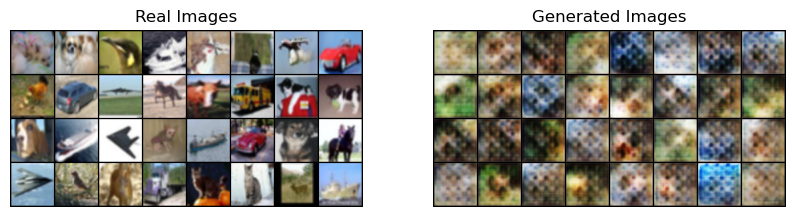

Epoch [10/50] Batch 390/391 Loss D: 0.599, Loss G: 0.795, FID: 304.685


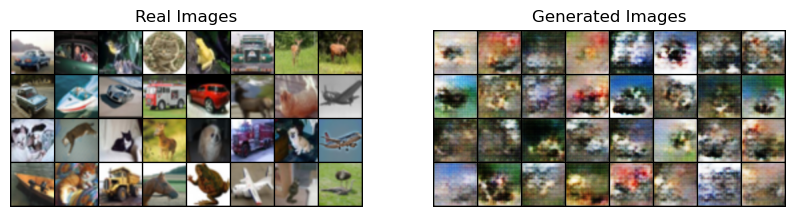

Epoch [15/50] Batch 390/391 Loss D: 1.214, Loss G: 1.835, FID: 258.757


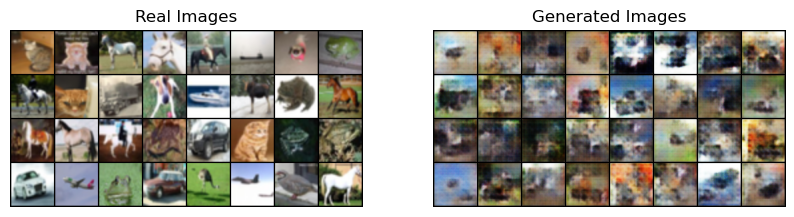

Epoch [20/50] Batch 390/391 Loss D: 0.650, Loss G: 0.733, FID: 248.249


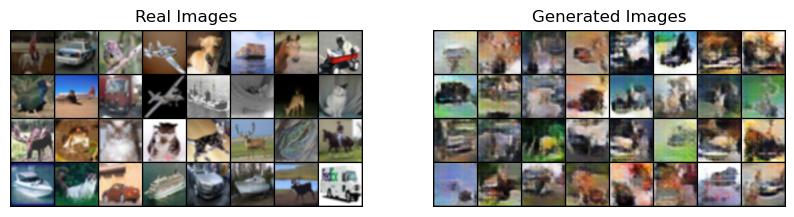

Epoch [25/50] Batch 390/391 Loss D: 0.661, Loss G: 0.735, FID: 217.070


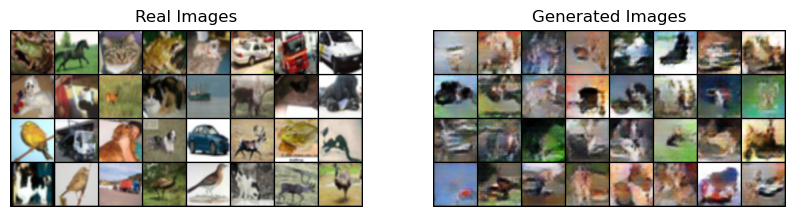

Epoch [30/50] Batch 390/391 Loss D: 0.653, Loss G: 0.964, FID: 212.805


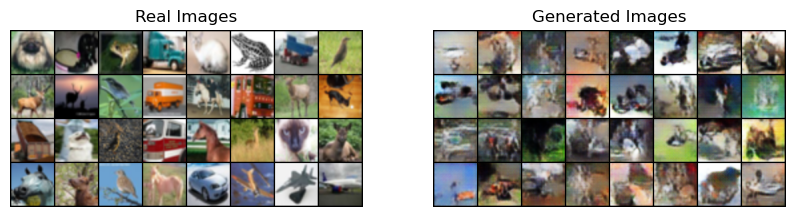

Epoch [35/50] Batch 390/391 Loss D: 0.633, Loss G: 1.167, FID: 219.423


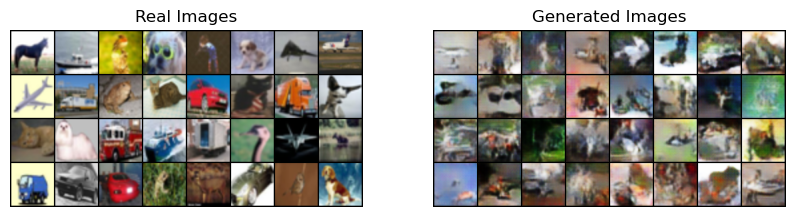

Epoch [40/50] Batch 390/391 Loss D: 0.664, Loss G: 0.898, FID: 190.679


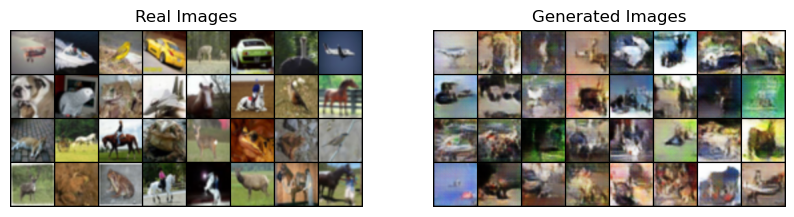

Epoch [45/50] Batch 390/391 Loss D: 0.618, Loss G: 0.735, FID: 193.592


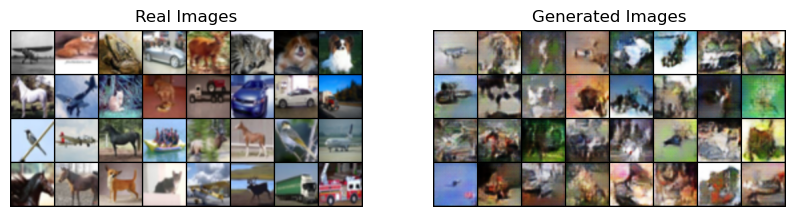

Epoch [50/50] Batch 390/391 Loss D: 0.716, Loss G: 0.612, FID: 197.494


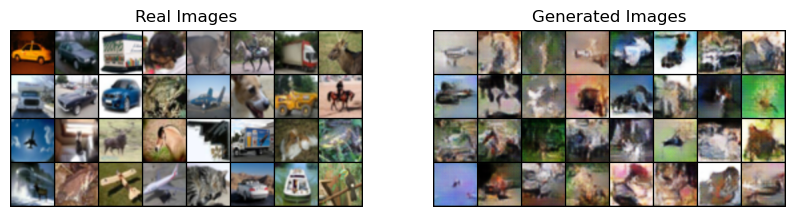



Elapsed time: 626.25 seconds.


In [64]:
import os
import time
import torch
import torchvision.utils as utils
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists for tracking metrics and outputs
GenLoss = []      # Generator loss for each iteration
DiscLoss = []     # Discriminator loss for each iteration
img_list = []     # Generated images for visualization
FID_list = []     # FID scores for each epoch
iters = 0         # Global iteration counter

print("!! Training Started !!")

# Start timing the training process
time_start = time.time()

# Training loop
for epoch in range(1, NUM_EPOCHS + 1):  # Start epoch index at 1
    for batch_idx, data in enumerate(dataloader, 0):
        ##########################
        ### Train Discriminator ###
        ##########################
        # Load real images and generate fake images
        real = data[0].to(device)
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
        fake = gen(noise)  # Generate fake images using the Generator

        # Discriminator loss on real images
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))

        # Discriminator loss on fake images
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

        # Total Discriminator loss
        loss_disc = (loss_disc_real + loss_disc_fake) / 2

        # Update Discriminator
        disc.zero_grad()
        loss_disc.backward()
        optimDiscriminator.step()

        ##########################
        ### Train Generator ###
        ##########################
        # Generator loss (maximize log(D(G(z))))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))

        # Update Generator
        gen.zero_grad()
        loss_gen.backward()
        optimGenerator.step()

        # Record losses
        GenLoss.append(loss_gen.item())
        DiscLoss.append(loss_disc.item())

        ##########################
        ### Visualization ###
        ##########################
        # Save generated images periodically
        if (iters % 500 == 0) or ((epoch == NUM_EPOCHS) and (batch_idx == len(dataloader) - 1)):
            with torch.no_grad():
                fake_images = gen(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake_images, padding=2, normalize=True))

        iters += 1

    ##########################
    ### Compute FID Score ###
    ##########################
    fretchet_dist = calculate_fretchet(real, fake, model)
    FID_list.append(fretchet_dist)

    # Log progress every 5 epochs
    if epoch % 5 == 0:
        print(f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} "
              f"Loss D: {loss_disc:.3f}, Loss G: {loss_gen:.3f}, FID: {fretchet_dist:.3f}")

        ##########################
        ### Display Images ###
        ##########################
        # Plot real and generated images every 5 epochs
        with torch.no_grad():
            fake_images = gen(fixed_noise).detach().cpu()

        plt.figure(figsize=(10, 5))

        # Real images
        plt.subplot(1, 2, 1)
        plt.axis("off")
        plt.title("Real Images")
        plt.imshow(
            np.transpose(
                utils.make_grid(real[:32], padding=2, normalize=True).cpu(), (1, 2, 0)
            )
        )

        # Generated images
        plt.subplot(1, 2, 2)
        plt.axis("off")
        plt.title("Generated Images")
        plt.imshow(
            np.transpose(
                utils.make_grid(fake_images[:32], padding=2, normalize=True), (1, 2, 0)
            )
        )

        plt.show()

    ##########################
    ### Save Epoch Results ###
    ##########################
    # Create directories for saving results
    os.makedirs('Results/DCGAN_FAKE', exist_ok=True)
    os.makedirs('Results/DCGAN_REAL', exist_ok=True)

    # Save generated images for the current epoch
    generated_images = gen(fixed_noise)
    utils.save_image(
        generated_images.detach(),
        f'Results/DCGAN_FAKE/DCGAN_epoch_{epoch:03d}.png',
        normalize=True
    )

    # Save real images for the current epoch
    utils.save_image(
        real.detach(),
        f'Results/DCGAN_REAL/DCGAN_epoch_{epoch:03d}.png',
        normalize=True
    )

# End timing
time_end = time.time()
print(f"\n\nElapsed time: {time_end - time_start:.2f} seconds.")


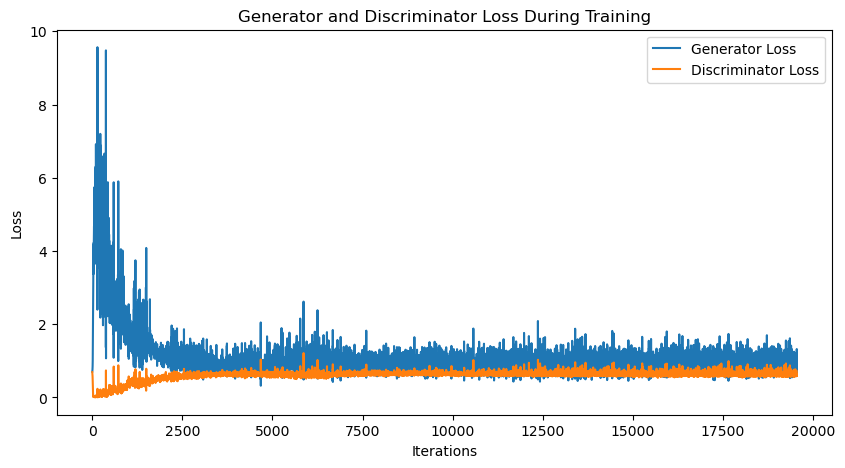

In [65]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Create directory for saving loss data if it doesn't exist
os.makedirs('Results/Loss_Data', exist_ok=True)

# Save Generator and Discriminator loss data to files
np.save('Results/Loss_Data/DCGAN_GLoss.npy', GenLoss)  # Save Generator losses
np.save('Results/Loss_Data/DCGAN_DLoss.npy', DiscLoss)  # Save Discriminator losses

# Load the saved loss data
GenLoss = np.load('Results/Loss_Data/DCGAN_GLoss.npy')
DiscLoss = np.load('Results/Loss_Data/DCGAN_DLoss.npy')

# Plot Generator and Discriminator losses
plt.figure(figsize=(10, 5))  # Set the size of the plot
plt.title("Generator and Discriminator Loss During Training")  # Add plot title

# Plot the losses
plt.plot(GenLoss, label="Generator Loss")  # Generator loss curve
plt.plot(DiscLoss, label="Discriminator Loss")  # Discriminator loss curve

# Add labels and legend
plt.xlabel("Iterations")  # X-axis label
plt.ylabel("Loss")  # Y-axis label
plt.legend()  # Add legend to the plot

# Save the plot as a PDF
os.makedirs('Results', exist_ok=True)  # Ensure the Results directory exists
plt.savefig('Results/loss.pdf', format='pdf', bbox_inches='tight')  # Save the plot

# Display the plot
plt.show()


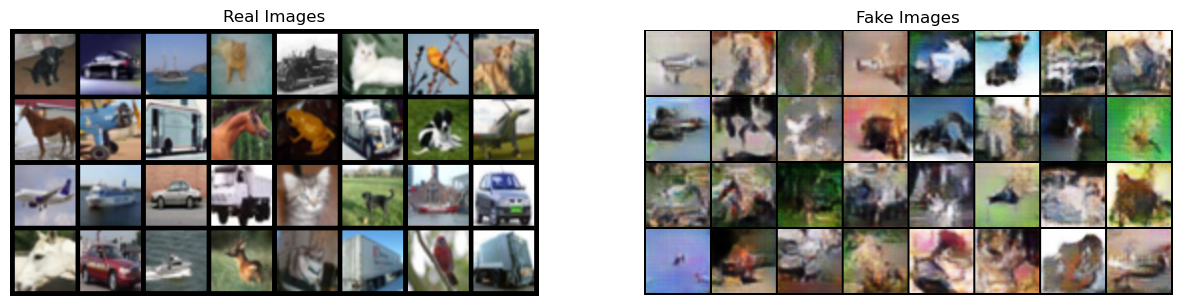

In [66]:
# Fetch a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Set up the figure for displaying real and fake images
plt.figure(figsize=(15, 15))

# Plot Real Images
plt.subplot(1, 2, 1)  # First subplot
plt.axis("off")       # Turn off the axis for a clean look
plt.title("Real Images")  # Add a title
plt.imshow(
    np.transpose(
        utils.make_grid(
            real_batch[0].to(device)[:32],  # Take the first 32 real images
            padding=5,                      # Add padding between images
            normalize=True                  # Normalize pixel values for display
        ).cpu(),
        (1, 2, 0)  # Transpose to match image format (H, W, C)
    )
)

# Plot Fake Images
plt.subplot(1, 2, 2)  # Second subplot
plt.axis("off")       # Turn off the axis
plt.title("Fake Images")  # Add a title
plt.imshow(
    np.transpose(
        img_list[-1],  # Use the last generated fake images from img_list
        (1, 2, 0)      # Transpose to match image format (H, W, C)
    )
)

# Save the figure to a PDF file
os.makedirs('Results', exist_ok=True)  # Ensure the Results directory exists
plt.savefig(
    'Results/DCGAN30_BEST_FAKE_32.pdf',  # Save the figure to this path
    format='pdf',                        # Save as PDF
    bbox_inches='tight'                  # Ensure tight layout
)

# Display the plot
plt.show()


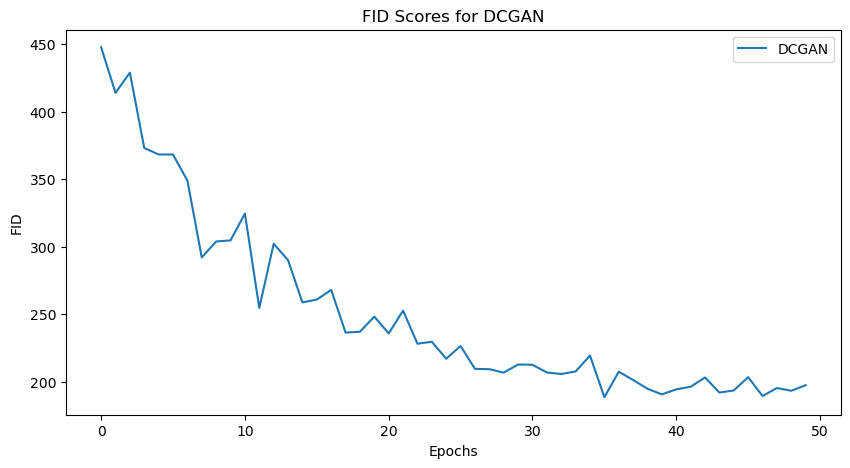

In [67]:
import matplotlib.pyplot as plt
import os

# Create a figure for plotting the FID scores
plt.figure(figsize=(10, 5))  # Set the figure size
plt.title("FID Scores for DCGAN")  # Add a title to the plot

# Plot FID scores
plt.plot(FID_list, label="DCGAN")  # Plot the FID scores with a label

# Add labels and legend
plt.xlabel("Epochs")  # Label for the x-axis
plt.ylabel("FID")     # Label for the y-axis
plt.legend()          # Add a legend to distinguish the plot

# Save the plot as a PDF file
os.makedirs('Results', exist_ok=True)  # Ensure the Results directory exists
plt.savefig(
    'Results/FID.pdf',  # Path to save the figure
    format='pdf',       # Save as PDF
    bbox_inches='tight'  # Ensure tight bounding box for a clean layout
)

# Display the plot
plt.show()


In [68]:
import os
import numpy as np

# Ensure the directory for saving FID scores exists
os.makedirs('Results/FID_score', exist_ok=True)

# Save the FID scores to a .npy file
np.save('Results/FID_score/DC_FID.npy', FID_list)

print("FID scores successfully saved to 'Results/FID_score/DC_FID.npy'")


FID scores successfully saved to 'Results/FID_score/DC_FID.npy'


In [69]:
np.min(FID_list), np.max(FID_list), np.mean(FID_list), FID_list[-1]

(188.57016525071813, 447.69231582501055, 251.04896926076606, 197.49375106118)

In [70]:
np.mean(GenLoss),np.mean(DiscLoss),np.min(GenLoss),np.min(DiscLoss),GenLoss[-1],DiscLoss[-1]

(1.045807469167063,
 0.597467157472773,
 0.3215624690055847,
 0.00741420965641737,
 0.6124001741409302,
 0.7155976295471191)